In [2]:
# setup
%matplotlib notebook
# set this to your working directory

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

X = pd.read_pickle('X.pkl').toarray()
df1 = pd.read_csv('death-penalty-cases.csv')
Y = df1['citeCount'] > 0

In [3]:
from sklearn.ensemble import GradientBoostingClassifier
boost = GradientBoostingClassifier()
boost.fit(X,Y)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [11]:
ypred = boost.predict_proba(X)[:,1]

/home/elliott/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


<IPython.core.display.Javascript object>


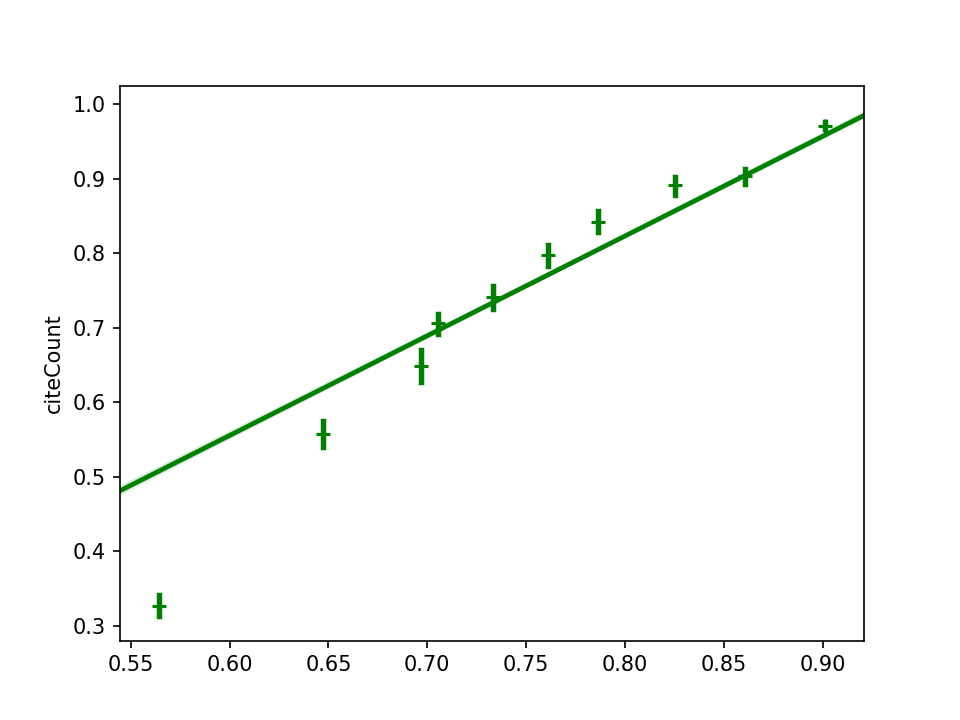

In [12]:
import seaborn as sns
plot = sns.regplot(ypred,
               Y, 
               color='g', 
               marker='+', 
               x_bins=10)

In [17]:
####
# Permutation Importance
###
from sklearn.metrics import mean_squared_error, make_scorer
from eli5.sklearn import PermutationImportance
perm = PermutationImportance(boost, random_state=1).fit(X,Y)

In [16]:
import eli5
vocab = pd.read_pickle('vocab.pkl')
eli5.show_weights(perm, feature_names = vocab)

Weight,Feature
0.0081 ± 0.0009,quot
0.0065 ± 0.0002,state did seek
0.0046 ± 0.0010,sanctions
0.0043 ± 0.0006,criminal
0.0036 ± 0.0004,sanction
0.0018 ± 0.0002,law
0.0017 ± 0.0001,direct
0.0015 ± 0.0002,texas
0.0013 ± 0.0001,habeas
0.0010 ± 0.0003,non death


# Text Classifer with LIME Example

In [30]:
from sklearn.base import BaseEstimator, TransformerMixin
from keras.models import Model, Input
from keras.layers import Dense, LSTM, Dropout, Embedding, SpatialDropout1D, Bidirectional, concatenate
from keras.layers import GlobalAveragePooling1D, GlobalMaxPooling1D
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import accuracy_score
import regex as re
import numpy as np

class KerasTextClassifier(BaseEstimator, TransformerMixin):
    '''Wrapper class for keras text classification models that takes raw text as input.'''
    def __init__(self, max_words=30000, 
                 input_length=100, 
                 emb_dim=20, 
                 n_classes=4, 
                 epochs=5, 
                 batch_size=32):
        self.max_words = max_words
        self.input_length = input_length
        self.emb_dim = emb_dim
        self.n_classes = n_classes
        self.epochs = epochs
        self.bs = batch_size
        self.model = self._get_model()
        self.tokenizer = Tokenizer(num_words=self.max_words+1,
                                    lower=True, split=' ', oov_token="UNK")
    def _get_model(self):
        input_text = Input((self.input_length,))
        text_embedding = Embedding(input_dim=self.max_words + 2, 
                                   output_dim=self.emb_dim, 
                                   input_length=self.input_length, 
                                   mask_zero=False)(input_text)
        text_embedding = SpatialDropout1D(0.5)(text_embedding)
        bilstm = Bidirectional(LSTM(units=32, return_sequences=True, 
                                    recurrent_dropout=0.5))(text_embedding)
        x = concatenate([GlobalAveragePooling1D()(bilstm), 
                         GlobalMaxPooling1D()(bilstm)])
        x = Dropout(0.7)(x)
        x = Dense(512, activation="relu")(x)
        x = Dropout(0.6)(x)
        x = Dense(512, activation="relu")(x)
        x = Dropout(0.5)(x)
        out = Dense(units=self.n_classes, activation="softmax")(x)
        model = Model(input_text, out)
        model.compile(optimizer="adam",
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"])
        return model
    
    def _get_sequences(self, texts):
        seqs = self.tokenizer.texts_to_sequences(texts)
        return pad_sequences(seqs, maxlen=self.input_length, value=0)
    
    def _preprocess(self, texts):
        return [re.sub(r"\d", "DIGIT", x) for x in texts]
    
    def fit(self, X, y):
        '''
        Fit the vocabulary and the model.
        :params:
        X: list of texts.
        y: labels.
            '''
        self.tokenizer.fit_on_texts(self._preprocess(X))
        self.tokenizer.word_index = {e: i for e,i in self.tokenizer.word_index.items() if i <= self.max_words}
        self.tokenizer.word_index[self.tokenizer.oov_token] = self.max_words + 1
        seqs = self._get_sequences(self._preprocess(X))
        self.model.fit(seqs, y, batch_size=self.bs, epochs=self.epochs, validation_split=0.1)
        
    def predict_proba(self, X, y=None):
        seqs = self._get_sequences(self._preprocess(X))
        return self.model.predict(seqs)
        
    def predict(self, X, y=None):
        return np.argmax(self.predict_proba(X), axis=1)
        
    def score(self, X, y):
        y_pred = self.predict(X)
        return accuracy_score(y, y_pred)

In [31]:
text_model = KerasTextClassifier(epochs=20, max_words=20000, input_length=200)
text_model.fit(df1['snippet'],Y)

Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Train on 29310 samples, validate on 3257 samples
Epoch 1/20
29310/29310 [==============================] - 395s 13ms/step - loss: 0.5022 - acc: 0.7911 - val_loss: 1.0248 - val_acc: 0.4572
Epoch 2/20
29310/29310 [==============================] - 337s 11ms/step - loss: 0.3637 - acc: 0.8584 - val_loss: 0.9758 - val_acc: 0.5017
Epoch 3/20
29310/29310 [==============================] - 354s 12ms/step - loss: 0.3213 - acc: 0.8772 - val_loss: 0.9466 - val_acc: 0.5379
Epoch 4/20
29310/29310 [==============================] - 302s 10ms/step - loss: 0.2976 - acc: 0.8873 - val_loss: 0.8679 - val_acc: 0.5490
Epoch 5/20
29310/29310 [==============================] - 288s 10ms/step - loss: 0.2777 - acc: 0.8931 - val_loss: 0.8804 - val_acc: 0.5579
Epoch 6/20
29310/29310 [==============================] - 285s 10ms/step - loss: 0.2599 - acc: 0.8987 - val_loss: 0.9811 - val_acc: 0.5588
Epoch 7/20
29310/29310 [===============

In [43]:
from eli5.lime import TextExplainer
te = TextExplainer(random_state=42)

doc = df1['snippet'].iloc[2]
te.fit(doc, text_model.predict_proba)
te.show_prediction(targets=[1])

In [44]:
doc = df1['snippet'].iloc[15]
te.fit(doc, text_model.predict_proba)
te.show_prediction(targets=[1])

In [45]:
doc = df1['snippet'].iloc[32541]
te.fit(doc, text_model.predict_proba)
te.show_prediction(targets=[1])

In [ ]:
# Set up a Keras MLP
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout
from keras.layers.normalization import BatchNormalization
from keras.regularizers import l1_l2

model = Sequential()
model.add(Dense(64, 
                input_dim=X.shape[1], 
                kernel_initializer='he_normal',
                kernel_regularizer=l1_l2(l1=0.01,l2=.01),
                activity_regularizer=l1_l2(l1=0.01,l2=.01),
                use_bias=False))
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(Dropout(0.5))
model.add(Dense(64, 
                kernel_initializer='he_normal',
                kernel_regularizer=l1_l2(l1=0.01,l2=.01),
                activity_regularizer=l1_l2(l1=0.01,l2=.01),
                use_bias=False))
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(Dropout(0.5))
model.add(Dense(1,activation='sigmoid'))
model.summary()

# Compile and Fit
model.compile(loss='binary_crossentropy', # cost function
              optimizer='adam', # use adam as the optimizer
              metrics=['accuracy']) # compute accuracy, for scoring

from keras.callbacks import EarlyStopping
earlystop = EarlyStopping(monitor='val_acc', 
                          min_delta=0.0001, 
                          patience=5, 
                          mode='auto')
model.fit(X, Y, batch_size=128, 
           epochs=100, 
           callbacks=[earlystop], 
           validation_split=0.2)